In [14]:
# pip install hypopt 

In [15]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from hypopt import GridSearch
from sklearn.linear_model import ElasticNet
import copy

In [16]:
train = pd.read_csv('preprocessed_train.csv')
test = pd.read_csv('preprocessed_test.csv')


# Removing the last event from each case to reduce noise in the models

In [17]:
train.drop(train.groupby('case concept:name').tail(1).index, axis=0, inplace=True)
test.drop(test.groupby('case concept:name').tail(1).index, axis=0, inplace=True)

# Evaluation


In [18]:
def time_evaluation(y_test, y_pred, model: str):
    print('\n')
    print(f"Error metrics (measured in hours) for the {model} when predicting the next event's Unix timestamp")
    
    print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_pred)/3600,2))
    print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_pred)/3600),2))
#     print('R2 score:', round(r2_score(y_test, y_pred),2))
    
    
def event_evaluation(y_test, y_pred, model: str, avg="weighted"):

    precision = precision_score(y_test, y_pred, average=avg, zero_division=0)
    recall = recall_score(y_test, y_pred, average=avg, zero_division=0)
    F1_score = f1_score(y_test, y_pred, average=avg, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    print('\n')
    print(f'Error metrics for the {model} when predicting the next event')
    
    print(f'Accuracy: {round(accuracy,2)}')
    print(f'Precision: {round(precision,2)}')
    print(f'Recall: {round(recall,2)}')
    print(f'f1-score: {round(F1_score,2)}')
#     print(confusion_matrix(y_test, y_pred))

# Data splitting and encoding

In [19]:
train_objs_num = train.shape[0]

dataset = pd.concat(objs=[train, test], axis=0)

dataset = dataset.replace({'event lifecycle:transition': {'SCHEDULE': 0, 'START': 1, 'COMPLETE': 2}})
dataset = pd.get_dummies(dataset, prefix = ['current', 'prev', '2prev'], 
                           columns = ['event concept:name', 'prev_event', '2prev_event'])

train_OHE = copy.copy(dataset[:train_objs_num])
test_OHE = copy.copy(dataset[train_objs_num:])



val_OHE = train_OHE.loc[147054:]
train_OHE = train_OHE.loc[:147054]

first_val_event_timestamp = val_OHE['event time:timestamp'].min()
train_OHE = train_OHE.groupby('case concept:name').filter(lambda g: g['event time:timestamp'].min() < first_val_event_timestamp and g['event time:timestamp'].max() < first_val_event_timestamp)

first_test_event_timestamp = test_OHE['event time:timestamp'].min()
val_OHE = val_OHE.groupby('case concept:name').filter(lambda g: g['event time:timestamp'].min() < first_test_event_timestamp and g['event time:timestamp'].max() < first_test_event_timestamp)


In [20]:
train_OHE.shape, val_OHE.shape, test_OHE.shape

((114600, 95), (33794, 95), (38911, 95))

In [21]:
lst = []
for element in list(train_OHE.columns):
    if element not in list(test_OHE.columns):
        lst.append(element)
print('event type that happen in the train but not the test set: ' + str(lst))

event type that happen in the train but not the test set: []


In [22]:
features_time = ['timestamp_finish', 'seconds_prev', 'active cases', 'day_week', 'time_of_day', 
                 'case AMOUNT_REQ', 'event lifecycle:transition', 
                 'current_A_ACCEPTED', 'current_A_ACTIVATED', 'current_A_APPROVED', 'current_A_CANCELLED', 'current_A_DECLINED', 'current_A_FINALIZED', 'current_A_PARTLYSUBMITTED', 'current_A_PREACCEPTED', 'current_A_REGISTERED', 'current_A_SUBMITTED', 'current_O_ACCEPTED','current_O_CANCELLED', 'current_O_CREATED', 'current_O_DECLINED','current_O_SELECTED', 'current_O_SENT', 'current_O_SENT_BACK','current_W_Afhandelen leads', 'current_W_Beoordelen fraude','current_W_Completeren aanvraag','current_W_Nabellen incomplete dossiers', 'current_W_Nabellen offertes','current_W_Valideren aanvraag', 'current_W_Wijzigen contractgegevens']

# features_time_test = ['timestamp_finish', 'seconds_prev', 'active cases', 'day_week', 'time_of_day', 
#                  'case AMOUNT_REQ', 'event lifecycle:transition', 
#            'current_A_ACCEPTED', 'current_A_ACTIVATED', 'current_A_APPROVED','current_A_CANCELLED', 'current_A_DECLINED', 'current_A_FINALIZED','current_A_PARTLYSUBMITTED', 'current_A_PREACCEPTED','current_A_REGISTERED', 'current_A_SUBMITTED', 'current_O_ACCEPTED', 'current_O_CANCELLED', 'current_O_CREATED', 'current_O_DECLINED','current_O_SELECTED', 'current_O_SENT', 'current_O_SENT_BACK','current_W_Afhandelen leads', 'current_W_Beoordelen fraude','current_W_Completeren aanvraag','current_W_Nabellen incomplete dossiers', 'current_W_Nabellen offertes', 'current_W_Valideren aanvraag']
features_time_test = features_time.copy()

target_time = 'seconds_next'

features_event = ['active cases', 'day_week', 'time_of_day',  
                  'event lifecycle:transition', 'case AMOUNT_REQ', 
       'current_A_ACCEPTED', 'current_A_ACTIVATED', 'current_A_APPROVED','current_A_CANCELLED', 'current_A_DECLINED', 'current_A_FINALIZED','current_A_PARTLYSUBMITTED', 'current_A_PREACCEPTED','current_A_REGISTERED', 'current_A_SUBMITTED', 'current_O_ACCEPTED','current_O_CANCELLED', 'current_O_CREATED', 'current_O_DECLINED','current_O_SELECTED', 'current_O_SENT', 'current_O_SENT_BACK','current_W_Afhandelen leads', 'current_W_Beoordelen fraude','current_W_Completeren aanvraag','current_W_Nabellen incomplete dossiers', 'current_W_Nabellen offertes','current_W_Valideren aanvraag', 'current_W_Wijzigen contractgegevens','prev_A_ACCEPTED', 'prev_A_ACTIVATED', 'prev_A_APPROVED','prev_A_CANCELLED', 'prev_A_DECLINED', 'prev_A_FINALIZED','prev_A_PARTLYSUBMITTED', 'prev_A_PREACCEPTED', 'prev_A_REGISTERED','prev_A_SUBMITTED', 'prev_FIRST EVENT', 'prev_O_ACCEPTED', 'prev_O_CANCELLED', 'prev_O_CREATED', 'prev_O_DECLINED','prev_O_SELECTED', 'prev_O_SENT', 'prev_O_SENT_BACK','prev_W_Afhandelen leads', 'prev_W_Beoordelen fraude','prev_W_Completeren aanvraag', 'prev_W_Nabellen incomplete dossiers','prev_W_Nabellen offertes', 'prev_W_Valideren aanvraag','prev_W_Wijzigen contractgegevens', '2prev_A_ACCEPTED','2prev_A_ACTIVATED', '2prev_A_APPROVED', '2prev_A_CANCELLED','2prev_A_FINALIZED', '2prev_A_PARTLYSUBMITTED', '2prev_A_PREACCEPTED','2prev_A_REGISTERED', '2prev_A_SUBMITTED', '2prev_FIRST EVENT','2prev_O_ACCEPTED', '2prev_O_CANCELLED', '2prev_O_CREATED','2prev_O_SELECTED', '2prev_O_SENT', '2prev_O_SENT_BACK','2prev_W_Afhandelen leads', '2prev_W_Beoordelen fraude','2prev_W_Completeren aanvraag', '2prev_W_Nabellen incomplete dossiers','2prev_W_Nabellen offertes', '2prev_W_Valideren aanvraag','2prev_W_Wijzigen contractgegevens']

# features_event_test = ['active cases', 'day_week', 'time_of_day',  
#                   'event lifecycle:transition', 'case AMOUNT_REQ', 
#                        'current_A_ACCEPTED', 'current_A_ACTIVATED', 'current_A_APPROVED','current_A_CANCELLED', 'current_A_DECLINED', 'current_A_FINALIZED','current_A_PARTLYSUBMITTED', 'current_A_PREACCEPTED','current_A_REGISTERED', 'current_A_SUBMITTED', 'current_O_ACCEPTED','current_O_CANCELLED', 'current_O_CREATED', 'current_O_DECLINED','current_O_SELECTED', 'current_O_SENT', 'current_O_SENT_BACK','current_W_Afhandelen leads', 'current_W_Beoordelen fraude','current_W_Completeren aanvraag','current_W_Nabellen incomplete dossiers', 'current_W_Nabellen offertes','current_W_Valideren aanvraag','prev_A_ACCEPTED', 'prev_A_ACTIVATED', 'prev_A_APPROVED','prev_A_CANCELLED', 'prev_A_DECLINED', 'prev_A_FINALIZED','prev_A_PARTLYSUBMITTED', 'prev_A_PREACCEPTED', 'prev_A_REGISTERED','prev_A_SUBMITTED', 'prev_FIRST EVENT', 'prev_O_ACCEPTED','prev_O_CANCELLED', 'prev_O_CREATED', 'prev_O_DECLINED','prev_O_SELECTED', 'prev_O_SENT', 'prev_O_SENT_BACK','prev_W_Afhandelen leads', 'prev_W_Beoordelen fraude','prev_W_Completeren aanvraag', 'prev_W_Nabellen incomplete dossiers','prev_W_Nabellen offertes', 'prev_W_Valideren aanvraag','2prev_A_ACCEPTED', '2prev_A_ACTIVATED', '2prev_A_APPROVED','2prev_A_FINALIZED', '2prev_A_PARTLYSUBMITTED', '2prev_A_PREACCEPTED','2prev_A_REGISTERED', '2prev_A_SUBMITTED', '2prev_FIRST EVENT','2prev_O_ACCEPTED', '2prev_O_CANCELLED', '2prev_O_CREATED','2prev_O_SELECTED', '2prev_O_SENT', '2prev_O_SENT_BACK','2prev_W_Afhandelen leads', '2prev_W_Beoordelen fraude','2prev_W_Completeren aanvraag', '2prev_W_Nabellen incomplete dossiers','2prev_W_Nabellen offertes', '2prev_W_Valideren aanvraag']
features_event_test = features_event.copy()

target_event = 'next_event'


# TIME
X_train_time = train_OHE[features_time]
y_train_time = train_OHE[target_time]

X_val_time = val_OHE[features_time]
y_val_time = val_OHE[target_time]

X_test_time = test_OHE[features_time_test].copy()
y_test_time = test_OHE[target_time]


# EVENT
X_train_event = train_OHE[features_event]
y_train_event = train_OHE[target_event]

X_val_event = val_OHE[features_event]
y_val_event = val_OHE[target_event]

X_test_event = test_OHE[features_event_test].copy()
y_test_event = test_OHE[target_event]



# X_test_time['current_W_Wijzigen contractgegevens']=-1
# X_test_event[['current_W_Wijzigen contractgegevens', 'prev_W_Wijzigen contractgegevens', '2prev_A_CANCELLED', '2prev_W_Wijzigen contractgegevens']]=-1

In [23]:
X_train_event.shape, X_train_time.shape, X_test_event.shape, X_test_time.shape

((114600, 77), (114600, 31), (38911, 77), (38911, 31))

In [24]:
# ohe = OneHotEncoder().fit(train['event concept:name'].to_numpy().reshape(-1, 1))

# transformed = ohe.transform(train['event concept:name'].to_numpy().reshape(-1, 1))
# train_OHE = pd.DataFrame(transformed, columns=jobs_encoder.get_feature_names())

# Event prediction

In [29]:
def RandomForestEvents(X_train, y_train, X_val, y_val):
    
    
    params={'max_depth': [15],
        'n_estimators': [600]}

    
    forest_clf = RandomForestClassifier(bootstrap=True, criterion='gini', max_features='sqrt', random_state=42)    
    
    grid = GridSearchCV(estimator=forest_clf, param_grid=params, n_jobs=6)

    grid.fit(X_train, y_train)
    
    return grid.best_estimator_


In [30]:
rf_event = RandomForestEvents(X_train_event, y_train_event, X_val_event, y_val_event)

In [31]:
rf_event_train = rf_event.predict(X_train_event)
rf_event_val = rf_event.predict(X_val_event)
rf_event_test = rf_event.predict(X_test_event)

In [32]:
print(rf_event.get_params())

event_evaluation(y_train_event, rf_event_train, 'RF EVENT TRAIN')
event_evaluation(y_val_event, rf_event_val, 'RF EVENT VAL')
event_evaluation(y_test_event, rf_event_test, 'RF EVENT TEST')

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 600, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Error metrics for the RF EVENT TRAIN when predicting the next event
Accuracy: 0.84
Precision: 0.85
Recall: 0.84
f1-score: 0.82


Error metrics for the RF EVENT VAL when predicting the next event
Accuracy: 0.8
Precision: 0.78
Recall: 0.8
f1-score: 0.77


Error metrics for the RF EVENT TEST when predicting the next event
Accuracy: 0.83
Precision: 0.8
Recall: 0.83
f1-score: 0.8


In [33]:
rf_event_features = dict(zip(features_event, rf_event.feature_importances_))

rf_event_features

# some categories of current, prev, 2prev event are very useful for next event -> current, prev, 2prev are good features

{'active cases': 9.334906955167905e-05,
 'day_week': 0.007381827673448484,
 'time_of_day': 0.02353109784514691,
 'event lifecycle:transition': 0.04446438846552574,
 'case AMOUNT_REQ': 0.01607920279624989,
 'current_A_ACCEPTED': 0.01265949065289792,
 'current_A_ACTIVATED': 0.0007861476614702207,
 'current_A_APPROVED': 0.0015444522068834886,
 'current_A_CANCELLED': 0.0044301886541508375,
 'current_A_DECLINED': 0.006011148811070773,
 'current_A_FINALIZED': 0.008330419199007533,
 'current_A_PARTLYSUBMITTED': 0.01200668273372736,
 'current_A_PREACCEPTED': 0.024662936908857618,
 'current_A_REGISTERED': 0.0007173013167272955,
 'current_A_SUBMITTED': 0.043721449145411394,
 'current_O_ACCEPTED': 0.002415898246404767,
 'current_O_CANCELLED': 0.005400178259172913,
 'current_O_CREATED': 0.029623550707016662,
 'current_O_DECLINED': 0.0012619891128230175,
 'current_O_SELECTED': 0.01406809727068153,
 'current_O_SENT': 0.014617934768572644,
 'current_O_SENT_BACK': 0.015261638457356333,
 'current_W_Afh

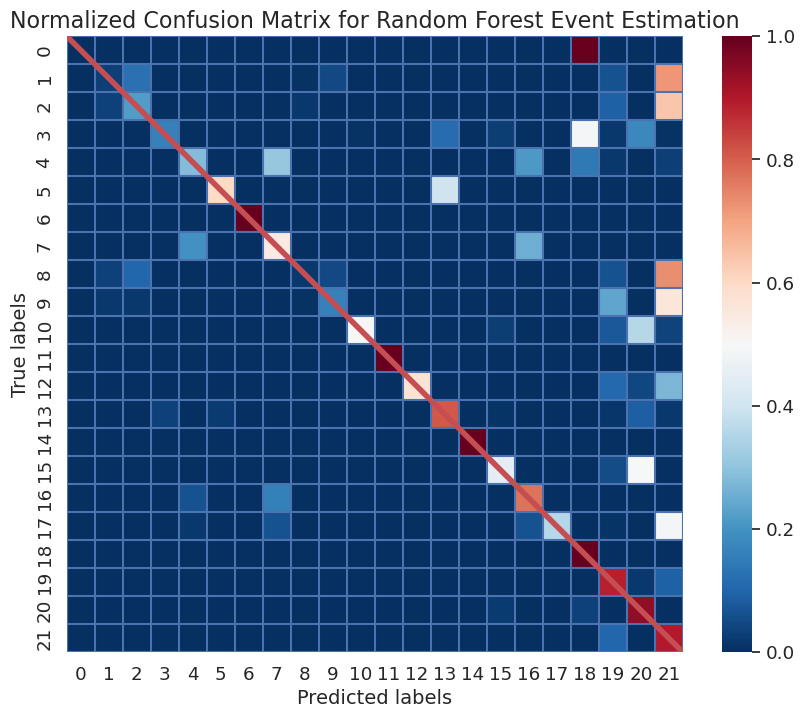

In [34]:
### Confusion matrix for event prediction ###
# # Random Forest estimator on test set

from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred_event are defined
cm = confusion_matrix(y_test_event, rf_event_test, normalize='true')

sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 8), facecolor='w')
sns.heatmap(cm, fmt='g', cmap='RdBu_r', ax=ax, annot_kws={"size": 14}, square=True)

ax.hlines([j for j in range(25)], *ax.get_xlim())
ax.vlines([j for j in range(25)], *ax.get_ylim())
ax.axline((1, 1), (24, 24), linewidth=4, color='r')

ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.set_title('Normalized Confusion Matrix for Random Forest Event Estimation', fontsize=16)
plt.show()



# Time prediction

In [37]:
def RandomForestTime(X_train, y_train, X_val, y_val):
    
    
    params={'max_depth': [10],
        'n_estimators': [1000]}

    forest_reg = RandomForestRegressor(bootstrap = True, max_features='sqrt', random_state=42)
    
    grid = GridSearchCV(estimator=forest_reg, param_grid=params, n_jobs=6)

    grid.fit(X_train, y_train)
    
    return grid.best_estimator_


In [38]:
rf_time = RandomForestTime(X_train_time, y_train_time, X_val_time, y_val_time)

In [39]:
rf_time_train = rf_time.predict(X_train_time)
rf_time_val = rf_time.predict(X_val_time)
rf_time_test = rf_time.predict(X_test_time)

In [40]:
print(rf_time.get_params())

time_evaluation(y_train_time, rf_time_train, 'RF TIME TRAIN')
time_evaluation(y_val_time, rf_time_val, 'RF TIME VAL')
time_evaluation(y_test_time, rf_time_test, 'RF TIME TEST')

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Error metrics (measured in hours) for the RF TIME TRAIN when predicting the next event's Unix timestamp
Mean Absolute Error: 10.08
Root Mean Squared Error: 1872.6


Error metrics (measured in hours) for the RF TIME VAL when predicting the next event's Unix timestamp
Mean Absolute Error: 8.35
Root Mean Squared Error: 1680.16


Error metrics (measured in hours) for the RF TIME TEST when predicting the next event's Unix timestamp
Mean Absolute Error: 9.67
Root Mean Squared Error: 1820.39


In [41]:
rf_time_features = dict(zip(features_time, rf_time.feature_importances_))

rf_time_features

# current event, current and prev time, note that active cases is relatively unimportant here too, mention cyclical time too

{'timestamp_finish': 0.03899795464964443,
 'seconds_prev': 0.21867630945836544,
 'active cases': 0.00015732032025762906,
 'day_week': 0.01962917099160595,
 'time_of_day': 0.022638339932082106,
 'case AMOUNT_REQ': 0.01411053140554309,
 'event lifecycle:transition': 0.2710644800559918,
 'current_A_ACCEPTED': 0.005301322915523864,
 'current_A_ACTIVATED': 0.00011033339275601374,
 'current_A_APPROVED': 0.0001067339329475809,
 'current_A_CANCELLED': 0.0005426802613448647,
 'current_A_DECLINED': 0.00526541252761679,
 'current_A_FINALIZED': 0.0018953029108498356,
 'current_A_PARTLYSUBMITTED': 0.008358295780993187,
 'current_A_PREACCEPTED': 0.010253750311193017,
 'current_A_REGISTERED': 0.00010450701284883481,
 'current_A_SUBMITTED': 0.007762604274105809,
 'current_O_ACCEPTED': 0.00024741430721528023,
 'current_O_CANCELLED': 0.0007555250076563175,
 'current_O_CREATED': 0.008227165683286587,
 'current_O_DECLINED': 3.8028858604558744e-05,
 'current_O_SELECTED': 0.004756200125145285,
 'current_O_S

In [42]:
# feature importances 
rf_event.feature_importances_
rf_event

RandomForestClassifier(max_depth=15, n_estimators=600, random_state=42)

# Elastic net

In [43]:
def ElasticNetTime(X_train, y_train, X_val, y_val):
    
    
    params = {"l1_ratio": [1],
              'alpha':[1],
             'max_iter':[5000]}

#     params = {"l1_ratio": [.5],
#               'alpha':[.5]}


    en_reg = ElasticNet(random_state=42)
    
    grid = GridSearch(model=en_reg, param_grid=params, parallelize=False)

    grid.fit(X_train, y_train, X_val, y_val)
    
    return grid.best_estimator_


In [44]:
en_time = ElasticNetTime(X_train_time, y_train_time, X_val_time, y_val_time)

In [45]:
en_time_train = en_time.predict(X_train_time)
en_time_val = en_time.predict(X_val_time)
en_time_test = en_time.predict(X_test_time)

In [46]:
print(en_time.get_params())

time_evaluation(y_train_time, en_time_train, 'EN TIME TRAIN')
time_evaluation(y_val_time, en_time_val, 'EN TIME VAL')
time_evaluation(y_test_time, en_time_test, 'EN TIME TEST')

{'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 1, 'max_iter': 5000, 'positive': False, 'precompute': False, 'random_state': 0, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


Error metrics (measured in hours) for the EN TIME TRAIN when predicting the next event's Unix timestamp
Mean Absolute Error: 14.87
Root Mean Squared Error: 2062.91


Error metrics (measured in hours) for the EN TIME VAL when predicting the next event's Unix timestamp
Mean Absolute Error: 13.21
Root Mean Squared Error: 1763.51


Error metrics (measured in hours) for the EN TIME TEST when predicting the next event's Unix timestamp
Mean Absolute Error: 14.85
Root Mean Squared Error: 1910.4


In [47]:
en_time_features = dict(zip(features_time, en_time.coef_))

en_time_features

{'timestamp_finish': -0.0018044799370348806,
 'seconds_prev': -0.12771392983261082,
 'active cases': -17115.1339078041,
 'day_week': 2462.959586665164,
 'time_of_day': 508.96557994374314,
 'case AMOUNT_REQ': -0.0901703002446455,
 'event lifecycle:transition': 73065.88315895341,
 'current_A_ACCEPTED': -3164.846984221033,
 'current_A_ACTIVATED': 0.0,
 'current_A_APPROVED': 0.0,
 'current_A_CANCELLED': -338.15607263580614,
 'current_A_DECLINED': -1637.7733510191733,
 'current_A_FINALIZED': -3463.0402429491496,
 'current_A_PARTLYSUBMITTED': -4400.694989554175,
 'current_A_PREACCEPTED': -4000.6532679963443,
 'current_A_REGISTERED': 0.0,
 'current_A_SUBMITTED': -4436.050666937958,
 'current_O_ACCEPTED': 0.0,
 'current_O_CANCELLED': -1697.2092589281162,
 'current_O_CREATED': -3183.814207086083,
 'current_O_DECLINED': 0.0,
 'current_O_SELECTED': -3166.1231237556517,
 'current_O_SENT': -3184.009011715892,
 'current_O_SENT_BACK': 563.9645913306912,
 'current_W_Afhandelen leads': 87179.6961983147

In [48]:
# sorted elastic net features by absolute value
sorted(en_time_features.items(), key=lambda x: abs(x[1]), reverse=True)

[('current_W_Wijzigen contractgegevens', 193604.2740262987),
 ('current_W_Nabellen offertes', 165918.4732848595),
 ('current_W_Completeren aanvraag', 110349.71436998817),
 ('current_W_Beoordelen fraude', 93884.50763983198),
 ('current_W_Valideren aanvraag', 87240.10219458307),
 ('current_W_Afhandelen leads', 87179.69619831473),
 ('event lifecycle:transition', 73065.88315895341),
 ('current_W_Nabellen incomplete dossiers', 70999.67440897053),
 ('active cases', -17115.1339078041),
 ('current_A_SUBMITTED', -4436.050666937958),
 ('current_A_PARTLYSUBMITTED', -4400.694989554175),
 ('current_A_PREACCEPTED', -4000.6532679963443),
 ('current_A_FINALIZED', -3463.0402429491496),
 ('current_O_SENT', -3184.009011715892),
 ('current_O_CREATED', -3183.814207086083),
 ('current_O_SELECTED', -3166.1231237556517),
 ('current_A_ACCEPTED', -3164.846984221033),
 ('day_week', 2462.959586665164),
 ('current_O_CANCELLED', -1697.2092589281162),
 ('current_A_DECLINED', -1637.7733510191733),
 ('current_O_SENT_B

# Decision Tree event

In [49]:
def DecisionTreeEvent(X_train, y_train, X_val, y_val):


    params={'max_depth': [8, 16, 32, 64, 128, None]}

    tree_clf = DecisionTreeClassifier(random_state=42)
    
    grid = GridSearch(model=tree_clf, param_grid=params, parallelize=False)

    grid.fit(X_train, y_train, X_val, y_val)
    
    return grid.best_estimator_



In [50]:
dt_event = DecisionTreeEvent(X_train_event, y_train_event, X_val_event, y_val_event)

In [51]:
dt_event_train = dt_event.predict(X_train_event)
dt_event_val = dt_event.predict(X_val_event)
dt_event_test = dt_event.predict(X_test_event)

In [52]:
print(dt_event.get_params())

event_evaluation(y_train_event, dt_event_train, 'DT EVENT TRAIN')
event_evaluation(y_val_event, dt_event_val, 'DT EVENT VAL')
event_evaluation(y_test_event, dt_event_test, 'DT EVENT TEST')

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}


Error metrics for the DT EVENT TRAIN when predicting the next event
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
f1-score: 0.92


Error metrics for the DT EVENT VAL when predicting the next event
Accuracy: 0.77
Precision: 0.78
Recall: 0.77
f1-score: 0.77


Error metrics for the DT EVENT TEST when predicting the next event
Accuracy: 0.79
Precision: 0.8
Recall: 0.79
f1-score: 0.8


In [53]:
dt_event_features = dict(zip(features_event, dt_event.feature_importances_))

dt_event_features

{'active cases': 0.00010871844903737872,
 'day_week': 0.03477333290806445,
 'time_of_day': 0.05001588810171122,
 'event lifecycle:transition': 0.031735095489763006,
 'case AMOUNT_REQ': 0.0747109996641813,
 'current_A_ACCEPTED': 0.003722387433179566,
 'current_A_ACTIVATED': 0.0028321635818129467,
 'current_A_APPROVED': 0.005153060018560649,
 'current_A_CANCELLED': 0.012628546753077013,
 'current_A_DECLINED': 0.009664028203280392,
 'current_A_FINALIZED': 2.0618446285064007e-05,
 'current_A_PARTLYSUBMITTED': 0.0,
 'current_A_PREACCEPTED': 0.031348989497806845,
 'current_A_REGISTERED': 0.0028197117630874803,
 'current_A_SUBMITTED': 0.07461430843886468,
 'current_O_ACCEPTED': 0.0057046432689246114,
 'current_O_CANCELLED': 0.010651903918637679,
 'current_O_CREATED': 0.035241001379647016,
 'current_O_DECLINED': 0.003864991157721397,
 'current_O_SELECTED': 0.02364483333639318,
 'current_O_SENT': 0.03067079519712621,
 'current_O_SENT_BACK': 0.026510106896761382,
 'current_W_Afhandelen leads': 1

In [54]:
dt_event.get_depth()

48

# Decision tree time

In [55]:
def DecisionTreeTime(X_train, y_train, X_val, y_val):

    params={'max_depth': [8, 16, 32, 64, 128, None]}

    tree_reg = DecisionTreeRegressor(random_state=42)
    
    grid = GridSearch(model=tree_reg, param_grid=params, parallelize=False)

    grid.fit(X_train, y_train, X_val, y_val)
    
    return grid.best_estimator_



In [56]:
dt_time = DecisionTreeTime(X_train_time, y_train_time, X_val_time, y_val_time)

In [57]:
dt_time_train = dt_time.predict(X_train_time)
dt_time_val = dt_time.predict(X_val_time)
dt_time_test = dt_time.predict(X_test_time)

In [58]:
print(dt_time.get_params())

time_evaluation(y_train_time, dt_time_train, 'DT TIME TRAIN')
time_evaluation(y_val_time, dt_time_val, 'DT TIME VAL')
time_evaluation(y_test_time, dt_time_test, 'DT TIME TEST')

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}


Error metrics (measured in hours) for the DT TIME TRAIN when predicting the next event's Unix timestamp
Mean Absolute Error: 0.0
Root Mean Squared Error: 0.0


Error metrics (measured in hours) for the DT TIME VAL when predicting the next event's Unix timestamp
Mean Absolute Error: 8.51
Root Mean Squared Error: 2144.71


Error metrics (measured in hours) for the DT TIME TEST when predicting the next event's Unix timestamp
Mean Absolute Error: 10.46
Root Mean Squared Error: 2437.06


In [59]:
dt_time_features = dict(zip(features_time, dt_time.feature_importances_))

dt_time_features

# active cases is stronger here

{'timestamp_finish': 0.23962835446678846,
 'seconds_prev': 0.26845009944900255,
 'active cases': 2.6598954273848013e-05,
 'day_week': 0.04319766516686453,
 'time_of_day': 0.06713960325460212,
 'case AMOUNT_REQ': 0.10742254715992985,
 'event lifecycle:transition': 0.19109721843033695,
 'current_A_ACCEPTED': 4.526081227121613e-08,
 'current_A_ACTIVATED': 9.846036174484638e-13,
 'current_A_APPROVED': 9.293739238948245e-10,
 'current_A_CANCELLED': 1.0483483238714457e-08,
 'current_A_DECLINED': 6.793258404359789e-12,
 'current_A_FINALIZED': 3.530755546345277e-12,
 'current_A_PARTLYSUBMITTED': 3.1007354571091227e-09,
 'current_A_PREACCEPTED': 1.2960836668157854e-13,
 'current_A_REGISTERED': 6.767325317465853e-13,
 'current_A_SUBMITTED': 9.69010595870739e-12,
 'current_O_ACCEPTED': 2.1815938023722803e-13,
 'current_O_CANCELLED': 1.0887550846967718e-12,
 'current_O_CREATED': 1.54665312281492e-16,
 'current_O_DECLINED': 4.950656997995058e-13,
 'current_O_SELECTED': 2.768484883306311e-12,
 'curr

In [60]:
dt_time.get_depth()

53

## Time, Memory and CPU usage

### Memory and CPU usage

In [61]:
# import psutil
# import time

# # start measuring CPU and memory usage
# process = psutil.Process()

# # start point
# start_time = time.time()

# forest_event, y_pred_event = RandomForestEvents(X_train, X_test, y_train, y_test)
# event_evaluation(y_test['next_event'], y_pred_event, 'Random forest classifier')
# # forest_time, y_pred_time = RandomForestTime(X_train, X_test, y_train, y_test)
# # time_evaluation(y_test['next_timestamp'], y_pred_time, 'Random forest regressor')
# # end point
# end_time = time.time()

# # calculate time taken
# elapsed_time = end_time - start_time
# print(f"Time taken: {elapsed_time:.2f} seconds")

# # measure CPU and memory usage
# cpu_usage = process.cpu_percent()
# memory_usage = process.memory_info().rss / 1024 / 1024  # in MB
# print(f"CPU usage: {cpu_usage:.2f}%")
# print(f"Memory usage: {memory_usage:.2f} MB")

### Time usage

In [ ]:
# start_time = time.time()

# # RandomForestEvents function
# forest_event, y_pred_event = RandomForestEvents(X_train, X_test, y_train, y_test)

# # event_evaluation function
# event_evaluation(y_test['next_event'], y_pred_event, 'Random forest classifier')

# print(f"Time taken by RandomForestEvents: {time.time() - start_time} seconds")

# start_time = time.time()

# # RandomForestTime function
# forest_time, y_pred_time = RandomForestTime(X_train, X_test, y_train, y_test)

# # # time_evaluation function
# # time_evaluation(y_test['next_timestamp'], y_pred_time, 'Random forest regressor')

# print(f"Time taken by RandomForestTime: {time.time() - start_time} seconds")

# Visualizations

### Confusion matrix for Random Forest estimator

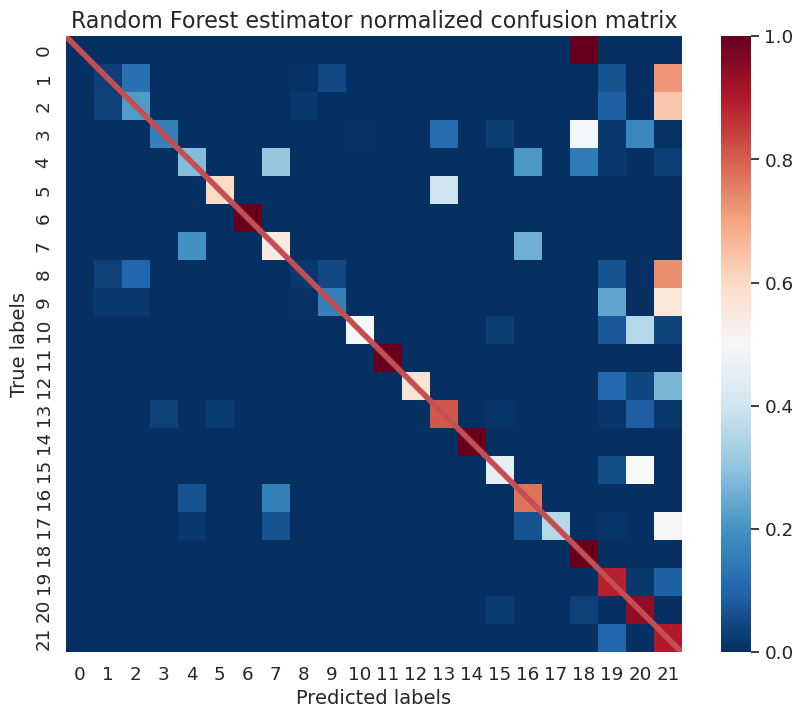

In [62]:
# # Random Forest estimator on test set

from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred_event are defined
cm = confusion_matrix(y_test_event, rf_event_test, normalize='true')

sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 8), facecolor='w')
sns.heatmap(cm, fmt='g', cmap='RdBu_r', ax=ax, annot_kws={"size": 14}, square=True)

# # Draw a diagonal line
# n_classes = cm.shape[0]
# for i in range(n_classes):
#     ax.plot([i, i + 1], [i + 1, i], color='black', linewidth=1)
# ax.hlines([j for j in range(25)], *ax.get_xlim())
# ax.vlines([j for j in range(25)], *ax.get_ylim())
ax.axline((1, 1), (24, 24), linewidth=4, color='r')

ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.set_title('Random Forest estimator normalized confusion matrix', fontsize=16)
plt.show()



### Bar chart for feature importance of Random Forest event estimator

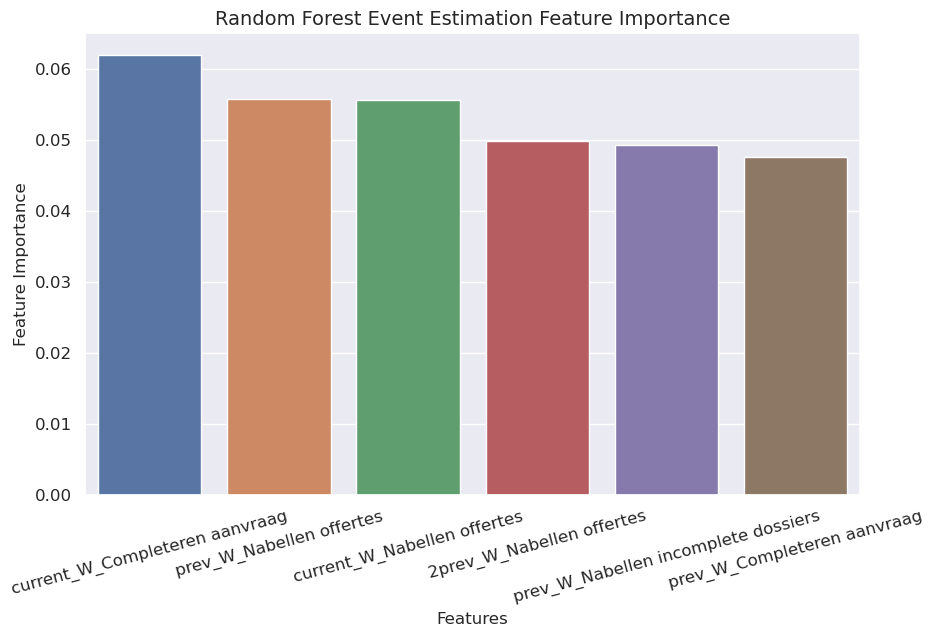

In [63]:
def filter_features(features, threshold):
    sorted_features = {k: v for k, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}
    return {k: v for k, v in sorted_features.items() if v > threshold}

def bar_plot(data, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=list(data.keys()), y=list(data.values()), ax=ax)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    plt.xticks(rotation=15, fontsize=12)  # Rotate x-labels and increase font size
    plt.yticks(fontsize=12)  # Increase y-labels font size
    plt.show()

important_features = filter_features(rf_event_features, 0.045)
bar_plot(important_features, 'Features', 'Feature Importance', 'Random Forest Event Estimation Feature Importance')


### Bar chart feature importance Random Forest time estimator

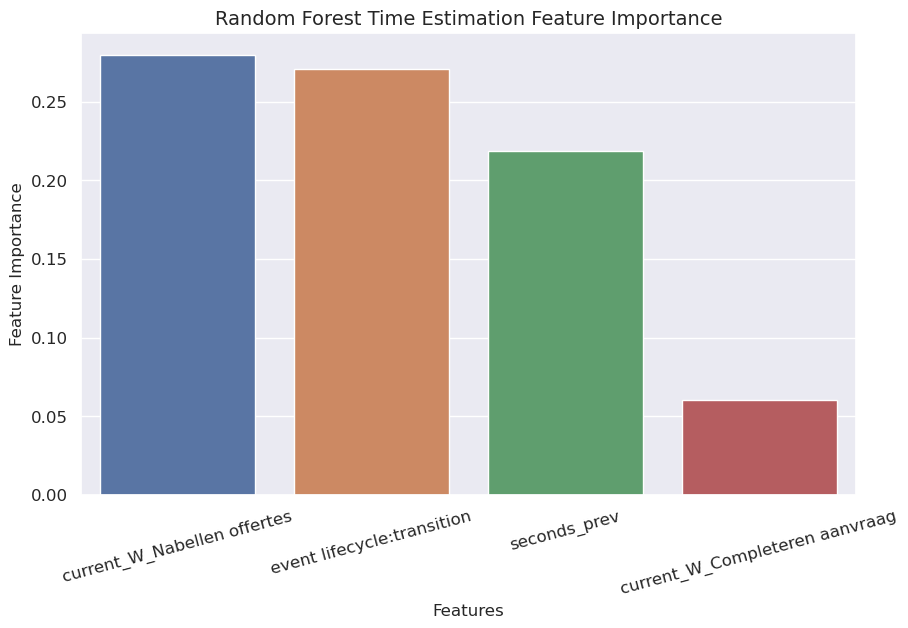

In [64]:
important_features = filter_features(rf_time_features, 0.045)
bar_plot(important_features, 'Features', 'Feature Importance', 'Random Forest Time Estimation Feature Importance')


### Bar chart feature importance Decision Tree time estimator

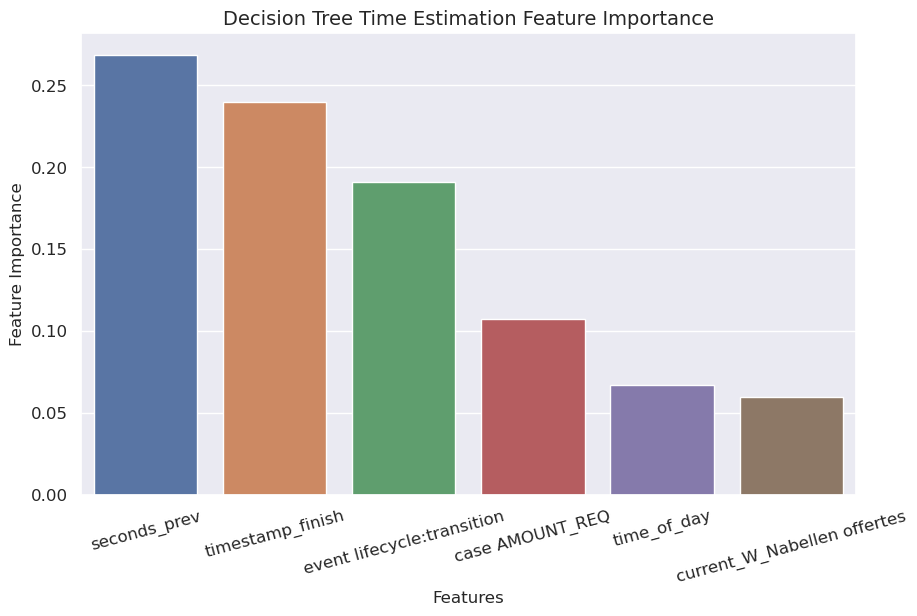

In [65]:
important_features = filter_features(dt_time_features, 0.045)
bar_plot(important_features, 'Features', 'Feature Importance', 'Decision Tree Time Estimation Feature Importance')


### Bar chart feature importance Decision Tree event estimator

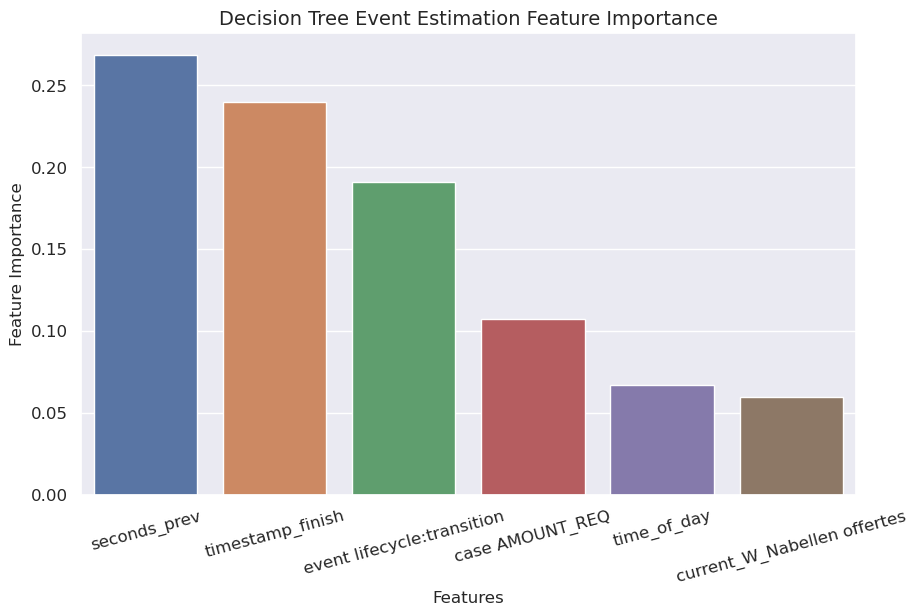

In [66]:
important_features = filter_features(dt_time_features, 0.045)
bar_plot(important_features, 'Features', 'Feature Importance', 'Decision Tree Event Estimation Feature Importance')


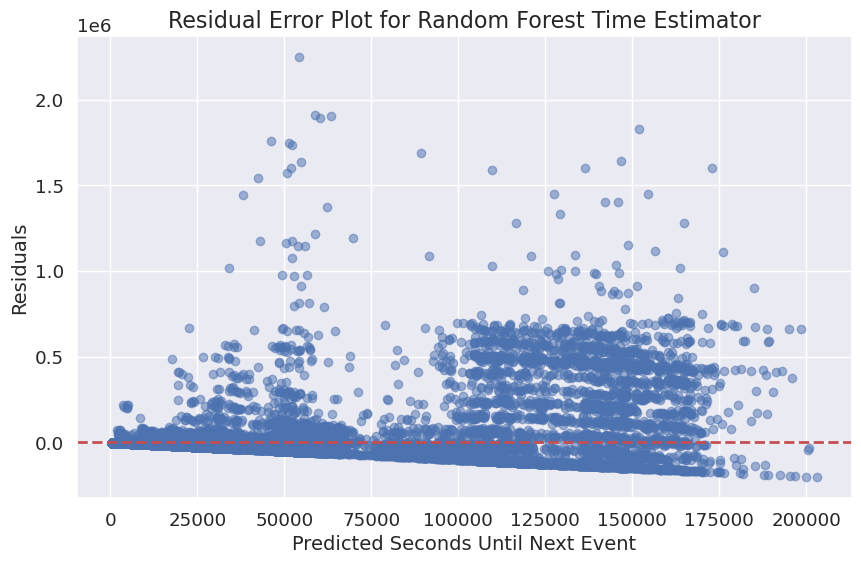

In [67]:
y_pred_time = rf_time.predict(X_test_time)

# Calculate residuals
residuals = y_test_time - y_pred_time

# Create a scatter plot of the predicted values vs. residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_time, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)

plt.xlabel('Predicted Seconds Until Next Event', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residual Error Plot for Random Forest Time Estimator', fontsize=16)
plt.show()


In [68]:
import timeit

# Function for measuring runtime for event estimation
def measure_runtime_event(model, X_train, y_train, X_val, y_val, X_test, y_test):
    start_train = timeit.default_timer()
    rf_event_train = rf_event.predict(X_train_event)
    end_train = timeit.default_timer()
    train_time = end_train - start_train

    start_val = timeit.default_timer()
    rf_event_val = rf_event.predict(X_val_event)
    end_val = timeit.default_timer()
    val_time = end_val - start_val

    start_test = timeit.default_timer()
    rf_event_test = rf_event.predict(X_test_event)
    end_test = timeit.default_timer()
    test_time = end_test - start_test

    print(f"Training time: {train_time:.4f} seconds")
    print(f"Validation time: {val_time:.4f} seconds")
    print(f"Testing time: {test_time:.4f} seconds")

# Function for measuring runtime for time estimation
def measure_runtime_time(model, X_train, y_train, X_val, y_val, X_test, y_test):
    start_train = timeit.default_timer()
    rf_time_train = rf_time.predict(X_train_time)
    #model.fit(X_train, y_train)
    end_train = timeit.default_timer()
    train_time = end_train - start_train

    start_val = timeit.default_timer()
    rf_time_val = rf_time.predict(X_val_time)
    #model.predict(X_val)
    end_val = timeit.default_timer()
    val_time = end_val - start_val

    start_test = timeit.default_timer()
    rf_time_test = rf_time.predict(X_test_time)
    #model.predict(X_test)
    end_test = timeit.default_timer()
    test_time = end_test - start_test

    print(f"Training time: {train_time:.4f} seconds")
    print(f"Validation time: {val_time:.4f} seconds")
    print(f"Testing time: {test_time:.4f} seconds")

# Measure runtime for the random forest event estimator
print("Random Forest Event Estimator Runtime:")
measure_runtime_event(rf_event, X_train_event, y_train_event, X_val_event, y_val_event, X_test_event, y_test_event)

# Measure runtime for the random forest time estimator
print("\nRandom Forest Time Estimator Runtime:")
measure_runtime_time(rf_time, X_train_time, y_train_time, X_val_time, y_val_time, X_test_time, y_test_time)


Random Forest Event Estimator Runtime:
Training time: 9.1435 seconds
Validation time: 2.5460 seconds
Testing time: 2.8684 seconds

Random Forest Time Estimator Runtime:
Training time: 2.8797 seconds
Validation time: 0.8018 seconds
Testing time: 0.9197 seconds
